In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/avito-demand-prediction/train_jpg_1.zip
/kaggle/input/avito-demand-prediction/test.csv
/kaggle/input/avito-demand-prediction/test_active.csv
/kaggle/input/avito-demand-prediction/test_jpg.zip
/kaggle/input/avito-demand-prediction/train_jpg_4.zip
/kaggle/input/avito-demand-prediction/sample_submission.csv
/kaggle/input/avito-demand-prediction/train.csv
/kaggle/input/avito-demand-prediction/train_jpg_0.zip
/kaggle/input/avito-demand-prediction/train_jpg.zip
/kaggle/input/avito-demand-prediction/periods_train.csv
/kaggle/input/avito-demand-prediction/train_jpg_3.zip
/kaggle/input/avito-demand-prediction/periods_test.csv
/kaggle/input/avito-demand-prediction/train_jpg_2.zip
/kaggle/input/avito-demand-prediction/train_active.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb
color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [3]:
train_data = pd.read_csv("/kaggle/input/avito-demand-prediction/train.csv")
test_data = pd.read_csv("/kaggle/input/avito-demand-prediction/test.csv")

In [60]:
train_data.head(5)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


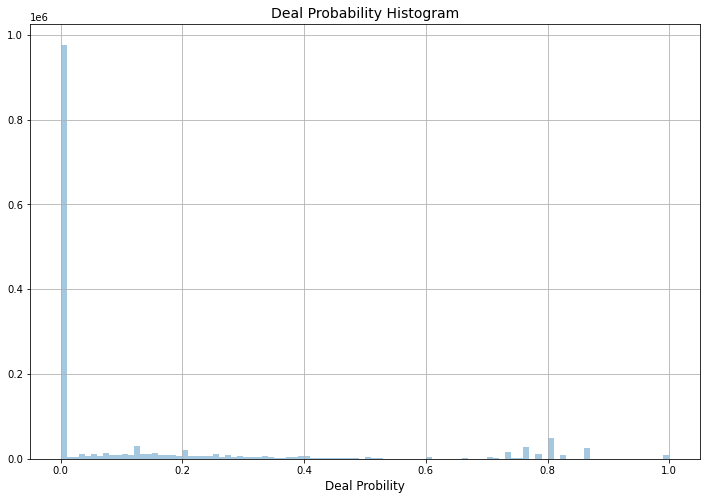

In [31]:
plt.figure(figsize=(12,8))
sns.distplot(train_data["deal_probability"].values, bins=100, kde=False)
plt.xlabel('Deal Probility', fontsize=12)
plt.title("Deal Probability Histogram", fontsize=14)
plt.grid(True)
plt.show()

In [4]:
from io import StringIO

temp_data = StringIO("""
region,region_en
Свердловская область, Sverdlovsk oblast
Самарская область, Samara oblast
Ростовская область, Rostov oblast
Татарстан, Tatarstan
Волгоградская область, Volgograd oblast
Нижегородская область, Nizhny Novgorod oblast
Пермский край, Perm Krai
Оренбургская область, Orenburg oblast
Ханты-Мансийский АО, Khanty-Mansi Autonomous Okrug
Тюменская область, Tyumen oblast
Башкортостан, Bashkortostan
Краснодарский край, Krasnodar Krai
Новосибирская область, Novosibirsk oblast
Омская область, Omsk oblast
Белгородская область, Belgorod oblast
Челябинская область, Chelyabinsk oblast
Воронежская область, Voronezh oblast
Кемеровская область, Kemerovo oblast
Саратовская область, Saratov oblast
Владимирская область, Vladimir oblast
Калининградская область, Kaliningrad oblast
Красноярский край, Krasnoyarsk Krai
Ярославская область, Yaroslavl oblast
Удмуртия, Udmurtia
Алтайский край, Altai Krai
Иркутская область, Irkutsk oblast
Ставропольский край, Stavropol Krai
Тульская область, Tula oblast
""")

region_df = pd.read_csv(temp_data)
train_data = pd.merge(train_data, region_df, how="left", on="region")

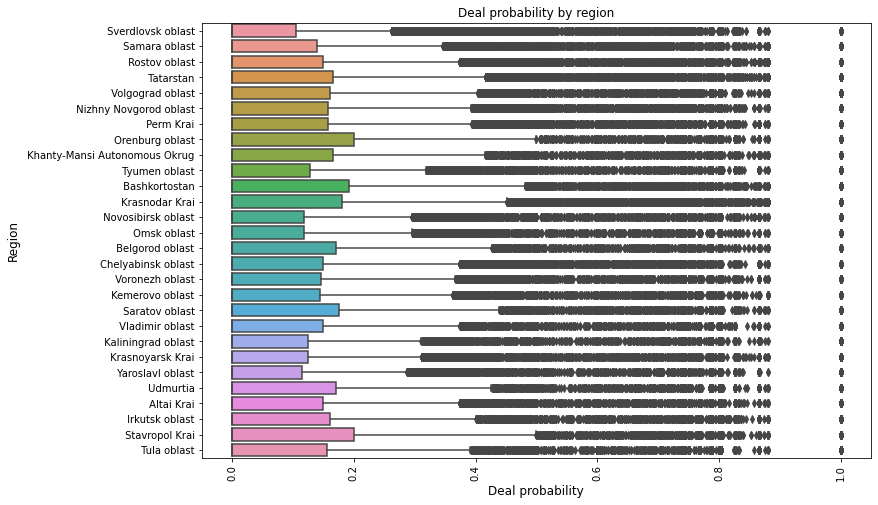

In [33]:
plt.figure(figsize=(12,8))
sns.boxplot(y="region_en", x="deal_probability", data=train_data)
plt.xlabel('Deal probability', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.title("Deal probability by region")
plt.xticks(rotation='vertical')
plt.show()

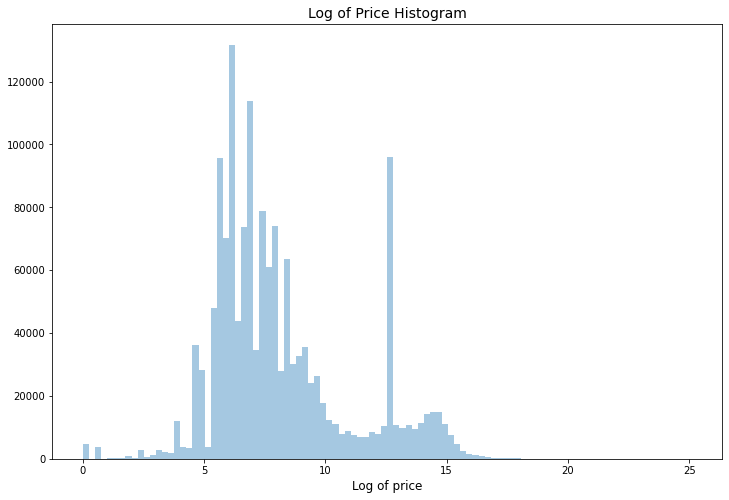

In [37]:
train_data["price_new"] = train_data["price"].values
train_data["price_new"].fillna(np.nanmean(train_data["price"].values), inplace=True)

plt.figure(figsize=(12,8))
sns.distplot(np.log1p(train_data["price_new"].values), bins=100, kde=False)
plt.xlabel('Log of price', fontsize=12)
plt.title("Log of Price Histogram", fontsize=14)
plt.show()

In [38]:
total = train_data.isnull().sum().sort_values(ascending = False)
percent = (train_data.isnull().sum() / train_data.isnull().count() * 100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head(10)

,Total,Percent
param_3,862565,57.373369
param_2,654542,43.536753
description,116276,7.734079
image_top_1,112588,7.488772
image,112588,7.488772
price,85362,5.677839
param_1,61576,4.095718
price_new,0,0.000000
user_id,0,0.000000
region,0,0.000000


In [21]:
# train_data.param_3 = train_data.param_3.fillna('')
# train_data.param_2 = train_data.param_2.fillna('')
# train_data.description = train_data.description.fillna('')
# train_data.image_top_1 = train_data.image_top_1.fillna('')
# train_data.image = train_data.image.fillna('')
# #train_data.price = train_data.price.fillna(0)
# train_data.param_1 = train_data.param_1.fillna('')

# import seaborn as sns
# ax = sns.heatmap(train_data)


In [5]:
conversion = StringIO("""
parent_category_name,parent_category_name_english
Личные вещи,Personal belongings
Для дома и дачи,For the home and garden
Бытовая электроника,Consumer electronics
Недвижимость,Real estate
Хобби и отдых,Hobbies & leisure
Транспорт,Transport
Услуги,Services
Животные,Animals
Для бизнеса,For business
""")

conversion = pd.read_csv(conversion)
train_data = pd.merge(train_data, conversion, on="parent_category_name", how="left")

In [63]:
temp = train_data["parent_category_name_english"].value_counts()
print("Total Top level ad category as classified by Avito's ad model : ",len(train["title"]))
trace = go.Bar(
    x = temp.index,
    y = (temp / temp.sum())*100,
)
data = [trace]
layout = go.Layout(
    title = "Top level ad category as classified by Avito's ad model",
    xaxis=dict(
        title='Top level ad category as classified by Avitos ad model',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of Top level ad category in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Total Top level ad category as classified by Avito's ad model :  1503424


In [6]:
temp_data = StringIO("""
category_name,category_name_en
"Одежда, обувь, аксессуары","Clothing, shoes, accessories"
Детская одежда и обувь,Children's clothing and shoes
Товары для детей и игрушки,Children's products and toys
Квартиры,Apartments
Телефоны,Phones
Мебель и интерьер,Furniture and interior
Предложение услуг,Offer services
Автомобили,Cars
Ремонт и строительство,Repair and construction
Бытовая техника,Appliances
Товары для компьютера,Products for computer
"Дома, дачи, коттеджи","Houses, villas, cottages"
Красота и здоровье,Health and beauty
Аудио и видео,Audio and video
Спорт и отдых,Sports and recreation
Коллекционирование,Collecting
Оборудование для бизнеса,Equipment for business
Земельные участки,Land
Часы и украшения,Watches and jewelry
Книги и журналы,Books and magazines
Собаки,Dogs
"Игры, приставки и программы","Games, consoles and software"
Другие животные,Other animals
Велосипеды,Bikes
Ноутбуки,Laptops
Кошки,Cats
Грузовики и спецтехника,Trucks and buses
Посуда и товары для кухни,Tableware and goods for kitchen
Растения,Plants
Планшеты и электронные книги,Tablets and e-books
Товары для животных,Pet products
Комнаты,Room
Фототехника,Photo
Коммерческая недвижимость,Commercial property
Гаражи и машиноместа,Garages and Parking spaces
Музыкальные инструменты,Musical instruments
Оргтехника и расходники,Office equipment and consumables
Птицы,Birds
Продукты питания,Food
Мотоциклы и мототехника,Motorcycles and bikes
Настольные компьютеры,Desktop computers
Аквариум,Aquarium
Охота и рыбалка,Hunting and fishing
Билеты и путешествия,Tickets and travel
Водный транспорт,Water transport
Готовый бизнес,Ready business
Недвижимость за рубежом,Property abroad
""")

temp_df = pd.read_csv(temp_data)
train_data = pd.merge(train_data, temp_df, on="category_name", how="left")

In [66]:
cnt_srs = train_data['category_name_en'].value_counts()
trace = go.Bar(
    y=cnt_srs.index[::-1],
    x=cnt_srs.values[::-1],
    orientation = 'h',
    marker=dict(
        color=cnt_srs.values[::-1],
        colorscale = 'Blues',
        reversescale = True
    ),
)

layout = dict(
    title='Category Name of Ads - Count',
    height=900
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="category name")

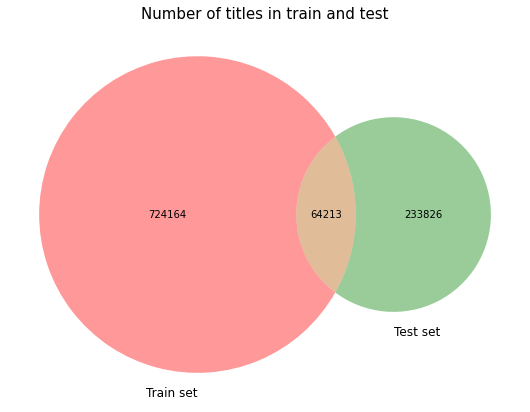

In [67]:
from matplotlib_venn import venn2

plt.figure(figsize=(10,7))
venn2([set(train_data.title.unique()), set(test_data.title.unique())], set_labels = ('Train set', 'Test set') )
plt.title("Number of titles in train and test", fontsize=15)
plt.show()

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning:

divide by zero encountered in log



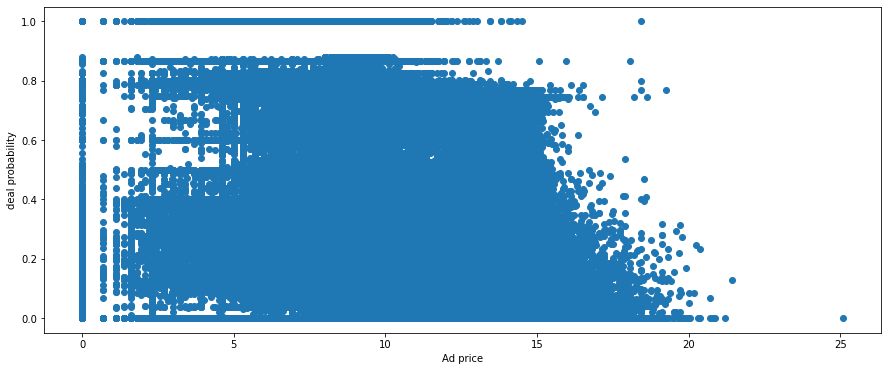

In [40]:
plt.figure(figsize=(15,6))
plt.scatter(np.log(train_data.price), train_data.deal_probability)
plt.xlabel('Ad price')
plt.ylabel('deal probability')
plt.show()

In [41]:
temp = train_data['user_type'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Distribution of user type')
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [7]:
#feature extraction
train_data['activation_date'] = pd.to_datetime(train_data['activation_date'])
test_data['activation_date'] = pd.to_datetime(test_data['activation_date'])


train_data["month"] = train_data["activation_date"].dt.month
train_data['weekday'] = train_data['activation_date'].dt.weekday
train_data["month_Day"] = train_data['activation_date'].dt.day
train_data["year_Day"] = train_data['activation_date'].dt.dayofyear


test_data["month"] = test_data["activation_date"].dt.month
test_data['weekday'] = test_data['activation_date'].dt.weekday
test_data["month_Day"] = test_data['activation_date'].dt.day
test_data["year_Day"] = test_data['activation_date'].dt.dayofyear 


In [8]:
from nltk.corpus import stopwords
from textblob import TextBlob
import datetime as dt
import warnings
import string
import time
# stop_words = []
stop_words = list(set(stopwords.words('russian')))
warnings.filterwarnings('ignore')
punctuation = string.punctuation

In [71]:
train_data["title_nwords"] = train_data["title"].apply(lambda x: len(str(x).split()))
test_data["title_nwords"] = test_data["title"].apply(lambda x: len(str(x).split()))

cnt_srs = train_data['title_nwords'].value_counts()

trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color="blue",
        #colorscale = 'Blues',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Number of words in title column'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="title_nwords")           

In [9]:
### TFIDF Vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,1))
full_tfidf = tfidf_vec.fit_transform(train_data['title'].values.tolist() + test_data['title'].values.tolist())
train_tfidf = tfidf_vec.transform(train_data['title'].values.tolist())
test_tfidf = tfidf_vec.transform(test_data['title'].values.tolist())


In [10]:

### SVD Components ###
n_comp = 3
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
train_svd.columns = ['svd_title_'+str(i+1) for i in range(n_comp)]
test_svd.columns = ['svd_title_'+str(i+1) for i in range(n_comp)]
train_data = pd.concat([train_data, train_svd], axis=1)
test_data = pd.concat([test_data, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

<Figure size 576x576 with 0 Axes>

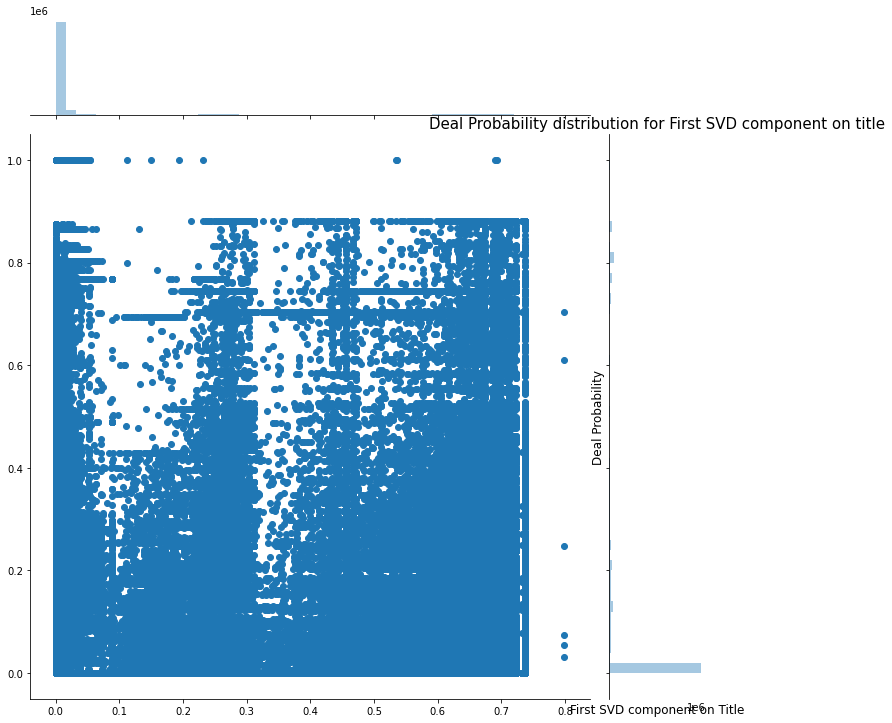

<Figure size 576x576 with 0 Axes>

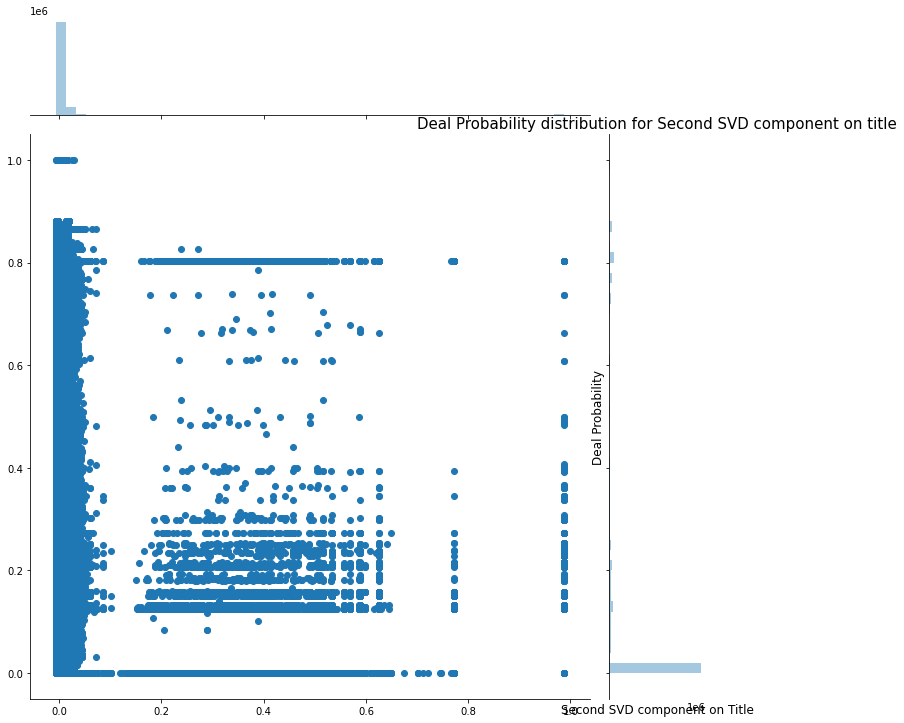

<Figure size 576x576 with 0 Axes>

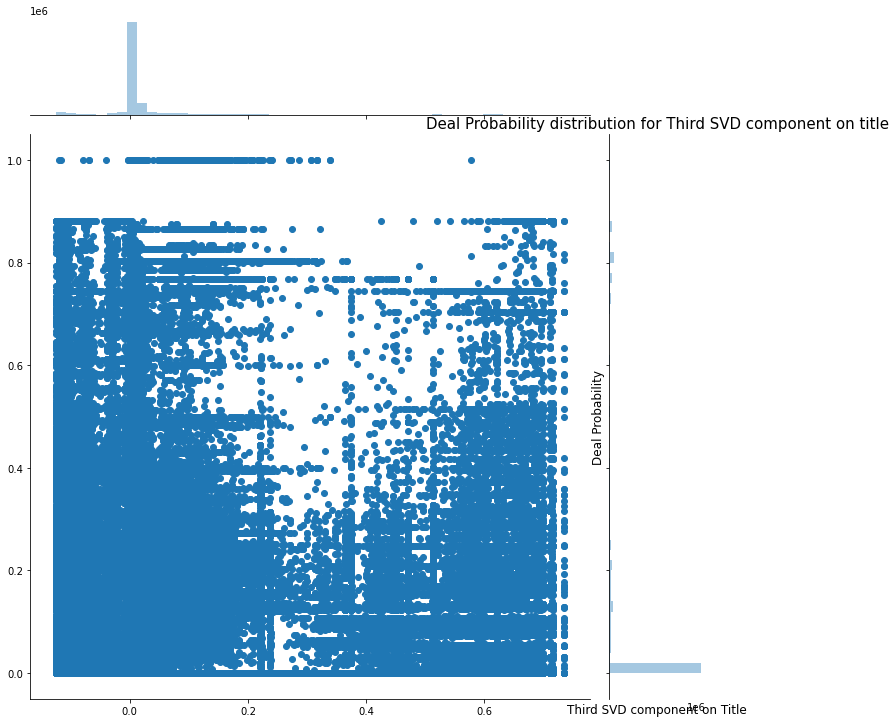

In [11]:
# 1st svd comp #
plt.figure(figsize=(8,8))
sns.jointplot(x=train_data["svd_title_1"].values, y=train_data["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('First SVD component on Title', fontsize=12)
plt.title("Deal Probability distribution for First SVD component on title", fontsize=15)
plt.show()

# 2nd svd comp #
plt.figure(figsize=(8,8))
sns.jointplot(x=train_data["svd_title_2"].values, y=train_data["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('Second SVD component on Title', fontsize=12)
plt.title("Deal Probability distribution for Second SVD component on title", fontsize=15)
plt.show()

# 3rd svd comp #
plt.figure(figsize=(8,8))
sns.jointplot(x=train_data["svd_title_3"].values, y=train_data["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('Third SVD component on Title', fontsize=12)
plt.title("Deal Probability distribution for Third SVD component on title", fontsize=15)
plt.show()

In [10]:
## Filling missing values ##
train_data["description"].fillna("NA", inplace=True)
test_data["description"].fillna("NA", inplace=True)

train_data["desc_nwords"] = train_data["description"].apply(lambda x: len(str(x).split()))
test_data["desc_nwords"] = test_data["description"].apply(lambda x: len(str(x).split()))

cnt_srs = train_data['desc_nwords'].value_counts().head(100)

trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color="blue",
        #colorscale = 'Blues',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Number of words in Description column'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="desc_nwords")  

In [77]:
# train_data.to_csv("temp_train_data.csv")
# test_data.to_csv("temp_test_data.csv")

In [78]:
train_data.head(5)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability,region_en,parent_category_name_english,category_name_en,month,weekday,month_Day,year_Day,title_nwords,svd_title_1,svd_title_2,svd_title_3,desc_nwords
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789,Sverdlovsk oblast,Personal belongings,Children's products and toys,3,1,28,87,3,0.000223,0.006494,0.006080,7
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000,Samara oblast,For the home and garden,Furniture and interior,3,6,26,85,3,0.000404,0.010513,0.010396,7
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177,Rostov oblast,Consumer electronics,Audio and video,3,0,20,79,2,0.000020,0.000027,0.000100,17
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323,Tatarstan,Personal belongings,Children's products and toys,3,5,25,84,1,0.000050,0.000224,0.000179,3
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797,Volgograd oblast,Transport,Cars,3,3,16,75,3,0.000004,0.000004,0.000029,4


In [11]:
import time

start_time=time.time()

def convert2str(x):
    temp = str(x)
    res = ""
    for o in temp:
        if o in punctuation:
             res += o
    return res


train_data['char_count'] = train_data['description'].apply(lambda x: len(str(x)))
train_data['word_count'] = train_data['description'].apply(lambda x: len(str(x).split()))
train_data['word_density'] = train_data['char_count'] / (train_data['word_count']+1)
train_data['punctuation_count'] = train_data['description'].apply(lambda x: len(convert2str(x))) 
train_data['title_word_count'] = train_data['description'].apply(lambda x: len([wrd for wrd in str(x).split() if wrd.istitle()]))
train_data['upper_case_word_count'] = train_data['description'].apply(lambda x: len([wrd for wrd in str(x).split() if wrd.isupper()]))
train_data['stopword_count'] = train_data['description'].apply(lambda x: len([wrd for wrd in str(x).split() if wrd.lower() in stop_words]))


test_data['char_count'] = test_data['description'].apply(lambda x: len(str(x)))
test_data['word_count'] = test_data['description'].apply(lambda x: len(str(x).split()))
test_data['word_density'] = test_data['char_count'] / (test_data['word_count']+1)
test_data['punctuation_count'] = test_data['description'].apply(lambda x: len(convert2str(x))) 
test_data['title_word_count'] = test_data['description'].apply(lambda x: len([wrd for wrd in str(x).split() if wrd.istitle()]))
test_data['upper_case_word_count'] = test_data['description'].apply(lambda x: len([wrd for wrd in str(x).split() if wrd.isupper()]))
test_data['stopword_count'] = test_data['description'].apply(lambda x: len([wrd for wrd in str(x).split() if wrd.lower() in stop_words]))

end_time=time.time()
print("total time in the cuurent cell ",end_time-start_time,"s")

total time in the cuurent cell  171.2001941204071 s


In [80]:
train_data.head(5)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability,region_en,parent_category_name_english,category_name_en,month,weekday,month_Day,year_Day,title_nwords,svd_title_1,svd_title_2,svd_title_3,desc_nwords,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,stopword_count
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789,Sverdlovsk oblast,Personal belongings,Children's products and toys,3,1,28,87,3,0.000223,0.006494,0.006080,7,58,7,7.250,2,1,0,1
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000,Samara oblast,For the home and garden,Furniture and interior,3,6,26,85,3,0.000404,0.010513,0.010396,7,41,7,5.125,3,2,1,3
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177,Rostov oblast,Consumer electronics,Audio and video,3,0,20,79,2,0.000020,0.000027,0.000100,17,99,17,5.500,5,3,2,4
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323,Tatarstan,Personal belongings,Children's products and toys,3,5,25,84,1,0.000050,0.000224,0.000179,3,22,3,5.500,1,1,0,0
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797,Volgograd oblast,Transport,Cars,3,3,16,75,3,0.000004,0.000004,0.000029,4,24,4,4.800,1,1,0,2


In [81]:
# #Converting Categorical featues to numericals features

# cat_vars = ["region", "city", "parent_category_name", "category_name", "user_type", "param_1", "param_2", "param_3"]
# for col in cat_vars:
#     lb = preprocessing.LabelEncoder()
#     lb.fit(list(train_data[col].values.astype('str')) + list(test_data[col].values.astype('str')))
#     train_data[col] = lb.transform(list(train_data[col].values.astype('str')))
#     test_data[col] = lb.transform(list(test_data[col].values.astype('str')))

In [12]:
# Target and ID variables #
train_y = train_data["deal_probability"].values
test_id = test_data["item_id"].values

# New variable on weekday #
train_data["activation_weekday"] = train_data["activation_date"].dt.weekday
test_data["activation_weekday"] = test_data["activation_date"].dt.weekday

# Label encode the categorical variables #
cat_vars = ["region", "city", "parent_category_name", "category_name", "user_type", "param_1", "param_2", "param_3"]
for col in cat_vars:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_data[col].values.astype('str')) + list(test_data[col].values.astype('str')))
    train_data[col] = lbl.transform(list(train_data[col].values.astype('str')))
    test_data[col] = lbl.transform(list(test_data[col].values.astype('str')))



In [13]:
cols_to_drop = ["item_id", "user_id", "title", "description", "activation_date", "image"]
train_X = train_data.drop(cols_to_drop + ["region_en", "parent_category_name_english", "category_name_en", "deal_probability"], axis=1)
test_X = test_data.drop(cols_to_drop, axis=1)

In [ ]:
# from sklearn.model_selection import KFold
# # Create a Cross Validation with 3 splits
# kf = KFold(n_splits=3)

# predictions = np.zeros(shape=[len(test_features)])

# evals_result = {}

# # For each KFold
# for train_indices ,validate_indices in kf.split(train_features) : 
#     train_data = lgb.Dataset(train_features.drop(['target'],axis=1).loc[train_indices,:],label=train_features.loc[train_indices,'target'])
#     val_data = lgb.Dataset(train_features.drop(['target'],axis=1).loc[validate_indices,:],label=train_features.loc[validate_indices,'target'])
    
#     lgtrain = lgb.Dataset(train_X, label=train_y)
#     lgval = lgb.Dataset(val_X, label=val_y)
    
#     params = {
#             'objective': 'binary',
#             'boosting': 'gbdt',
#             'learning_rate': 0.2 ,
#             'verbose': 0,
#             'num_leaves': 2**8,
#             'bagging_fraction': 0.95,
#             'bagging_freq': 1,
#             'bagging_seed': 1,
#             'feature_fraction': 0.9,
#             'feature_fraction_seed': 1,
#             'max_bin': 256,
#             'num_rounds': 80,
#             'metric' : ('auc', 'logloss')
#         }
                    
                
#     # Train the model    
#     lgbm_model = lgb.train(params, train_data, 100, valid_sets=[train_data, val_data],
#                            #feature_name=['f' + str(i + 1) for i in range(train_features.shape[-1]-1)],
#                            #categorical_feature=[35],
#                            evals_result=evals_result, verbose_eval=10)
#     #gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=[lgb_train, lgb_test], evals_result=evals_result, verbose_eval=10)
#     predictions += lgbm_model.predict(test_features.drop(['id'],axis=1))
#     #del lgbm_model
#     # We get the ammount of predictions from the prediction list, by dividing the predictions by the number of Kfolds.
# predictions = predictions/3


In [14]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
            'objective': 'binary',
            'boosting': 'gbdt',
            'learning_rate': 0.2 ,
            'verbose': 0,
            'num_leaves': 2**8,
            'bagging_fraction': 0.95,
            'bagging_freq': 1,
            'bagging_seed': 1,
            'feature_fraction': 0.9,
            'feature_fraction_seed': 1,
            'max_bin': 256,
            'num_rounds': 80,
            'metric' : ('rmse', 'auc', 'logloss')
        }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [15]:
dev_X = train_X.iloc[:-200000,:]
val_X = train_X.iloc[-200000:,:]
dev_y = train_y[:-200000]
val_y = train_y[-200000:]


pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

# Making a submission file #
pred_test[pred_test>1] = 1
pred_test[pred_test<0] = 0
sub_df = pd.DataFrame({"item_id":test_id})
sub_df["deal_probability"] = pred_test
sub_df.to_csv("baseline_lgb.csv", index=False)

Training until validation scores don't improve for 100 rounds
[20]	valid_0's rmse: 0.352105	valid_0's auc: 0.809301
[40]	valid_0's rmse: 0.353643	valid_0's auc: 0.812778
[60]	valid_0's rmse: 0.354176	valid_0's auc: 0.813684
[80]	valid_0's rmse: 0.354587	valid_0's auc: 0.81406
Did not meet early stopping. Best iteration is:
[2]	valid_0's rmse: 0.324592	valid_0's auc: 0.797639


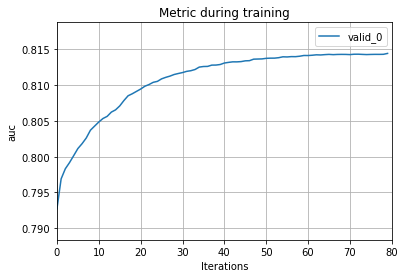

In [88]:
ax = lgb.plot_metric(evals_result, metric='auc')#metric的值与之前的params里面的值对应
plt.show()

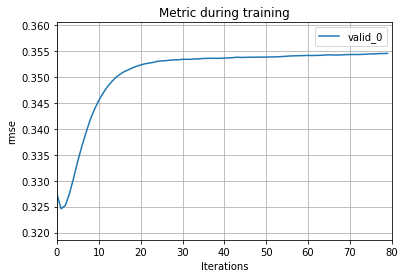

In [16]:
ax = lgb.plot_metric(evals_result, metric='rmse')#metric的值与之前的params里面的值对应
plt.show()

KeyError: 'No given metric in eval results.'

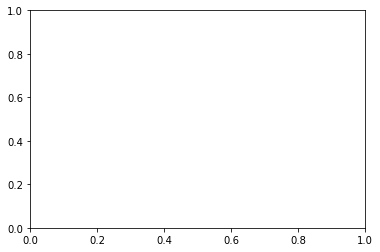

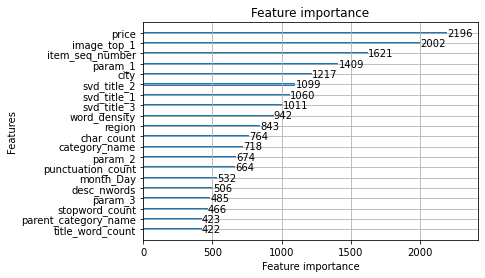

In [90]:
ax = lgb.plot_importance(model, max_num_features=20)
plt.show()